In [1]:
import numpy as np
import pandas as pd
from skimage.io import imread, imread_collection, imsave,imshow
from skimage.transform import resize
from skimage.filters import median,threshold_otsu, threshold_isodata, threshold_mean
from skimage.color import rgb2gray
from skimage.morphology import erosion,binary_erosion
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from skimage.filters import threshold_otsu

from skimage.filters import median
from skimage.morphology import square

from scipy import ndimage as ndi
from skimage.feature import canny

from skimage import util

In [2]:
def funcaoPlot(imagens, title = None):
    fig, ax = plt.subplots(1, len(imagens), figsize=(60,60)) 
    for i, folha in enumerate(imagens):
        ax[i].imshow(folha,cmap="gray")
        if title:
            ax[i].set_title(title[i])
        else:
            ax[i].set_title(str(i))

In [30]:
from sklearn.mixture import GaussianMixture
import cv2
from skimage.filters import threshold_niblack
from sklearn.cluster import KMeans, DBSCAN, estimate_bandwidth, MeanShift


def limiar_otsu(list_img):
    images = list_img
    list_img_bin = []
    for img in images:
        list_img_bin.append(aplicaOtsu(img))
    return list_img_bin

def aplicar_menshift(list_img):
    images = list_img
    list_img_bin = []
    for img in images:
        list_img_bin.append(aplicaMeanShift(img))
    return list_img_bin

def aplicar_gmm(list_img):
    images = list_img
    list_img_bin = []
    for img in images:
        list_img_bin.append(aplicaGMM(img))
    return list_img_bin

def aplicar_kmeans(list_img):
    images = list_img
    list_img_bin = []
    for img in images:
        list_img_bin.append(aplicaKmeans(img))
    return list_img_bin

def aplicar_niblack(list_img):
    images = list_img
    list_img_bin = []
    for img in images:
        list_img_bin.append(aplicaNiblack(img))
    return list_img_bin



def aplicaKmeans(img):
    model = KMeans(n_clusters=2, random_state=0).fit(np.reshape(img,(-1, 1)))
    segmented = model.predict(np.reshape(img,(-1, 1)))
    segmented = np.reshape(segmented,(img.shape[0],img.shape[1]))
    return segmented

def aplicaOtsu(img):
    thresh = threshold_otsu(img)
    binary = img > thresh
    return binary

def aplicaNiblack(img):
    thresh = threshold_niblack(img, window_size=69, k=0.5)
    binary = img > thresh
    return binary

def aplicaMeanShift(img):
    flat_img = img.reshape((-1, 1))

    bandwidth = estimate_bandwidth(flat_img, quantile=0.2, n_samples=500)

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(flat_img)

    labels = ms.labels_
    segmented = np.reshape(labels, img.shape)

    return segmented

def aplicaGMM(img, n_components=2):
    flat_img = img.reshape((-1, 1))

    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(flat_img)

    labels = gmm.predict(flat_img)

    segmented = np.reshape(labels, img.shape)

    return segmented

In [4]:
def dice(imagem, mascara, empty_score=1.0):
    imagem_b = np.asarray(imagem).astype(np.bool)
    mascara_b = np.asarray(mascara).astype(np.bool)
    
    if imagem_b.shape != mascara_b.shape:
        raise ValueError("Shape diferentes!")
    
    im_sum = imagem_b.sum() + mascara_b.sum()
    
    if im_sum == 0:
        return empty_score
    
    intersection = np.logical_and(imagem_b, mascara_b)
    
    return 2. * intersection.sum() / im_sum

def media_dice(imagem, mascara):
    soma = map(dice,imagem,mascara)
    return sum(list(soma))/len(imagem)

Lendo imagens

In [5]:
imagens = imread_collection('PH2Dataset/PH2 Dataset images/*/*'+'_Dermoscopic_Image/*')
mascaras_medico = imread_collection('PH2Dataset/PH2 Dataset images/*/*'+'_lesion/*')

In [6]:
imagens = imagens
mascaras_medico = mascaras_medico

redimenssionando e trasnsformando em tons de cinza

In [7]:
imagens_original = [np.array(resize((img),(512,512))) for img in imagens]
mascaras_medico = [np.array(resize(img,(512,512))) for img in mascaras_medico]
imagens_gray = [rgb2gray(img) for img in imagens_original]

/home/lucas/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/lucas/anaconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


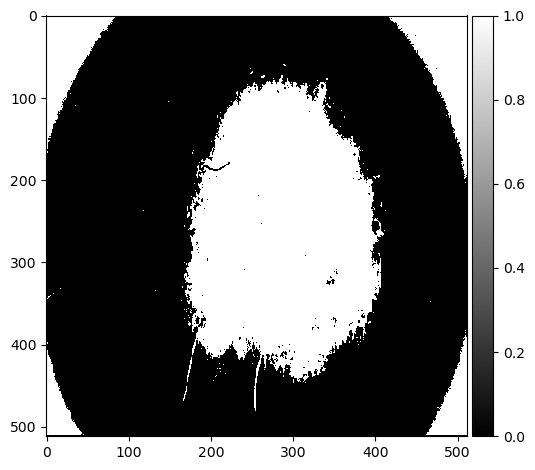

In [8]:
from skimage.io import imshow

img = aplicaKmeans(imagens_gray[0].copy())
imshow(img.copy(), cmap='gray')

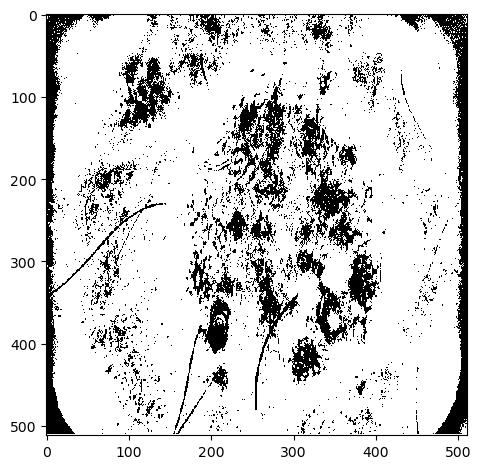

In [9]:
img_niblack = aplicaNiblack(imagens_gray[0].copy())
imshow(img_niblack, cmap='gray')

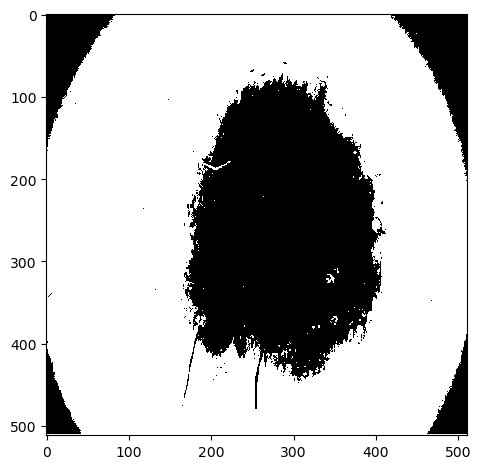

In [10]:
img_otsu = aplicaOtsu(imagens_gray[0].copy())
imshow(img_otsu, cmap='gray')

/home/lucas/anaconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


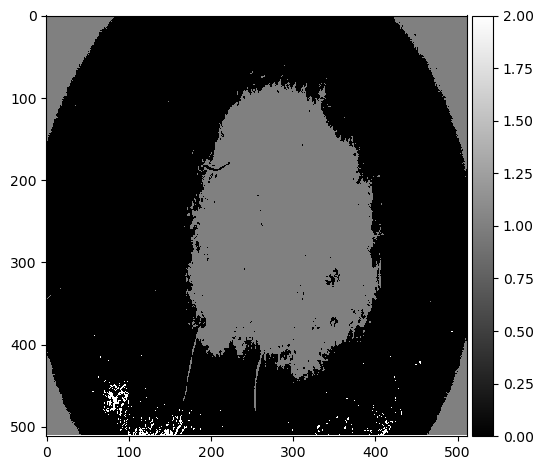

In [11]:
img_meanshift = aplicaMeanShift(imagens_gray[0].copy())
imshow(img_meanshift, cmap='gray')

/home/lucas/anaconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


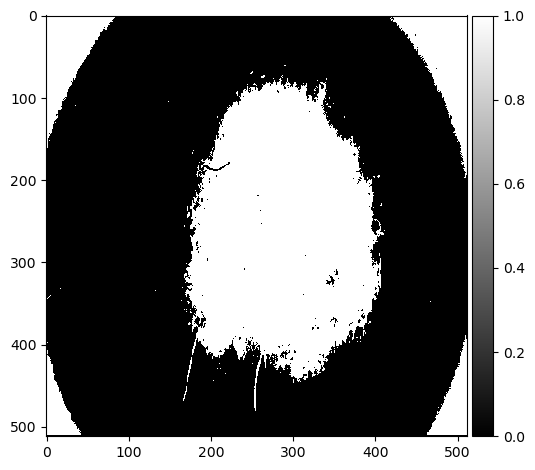

In [12]:
#Gaussian Mixture Models (GMM)
img_gmm = aplicaGMM(imagens_gray[0].copy())
imshow(img_gmm, cmap='gray')

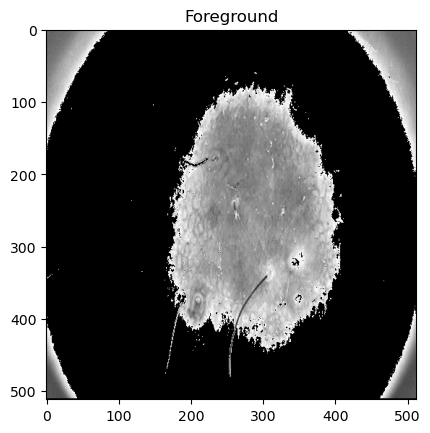

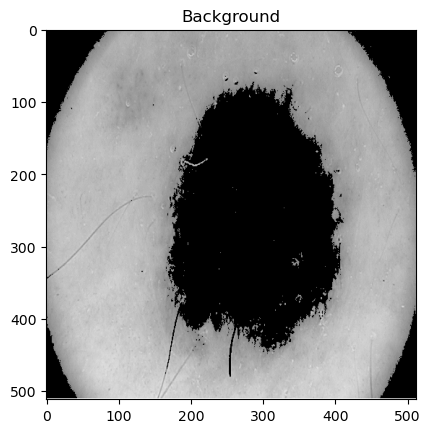

In [13]:
img = imagens_gray[0].copy()

foreground = (img - (img_otsu * img))
background = (img_otsu * img)

plt.figure()
plt.title('Foreground')
plt.imshow(foreground,cmap = 'gray')
plt.figure()
plt.title('Background')
plt.imshow(background,cmap = 'gray')

In [14]:
255 *False

0

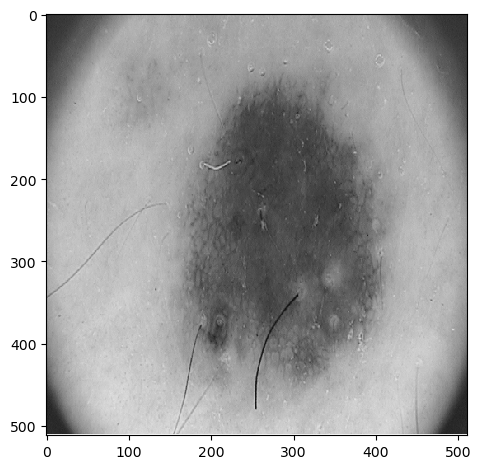

In [15]:
imshow(img,cmap = 'gray')

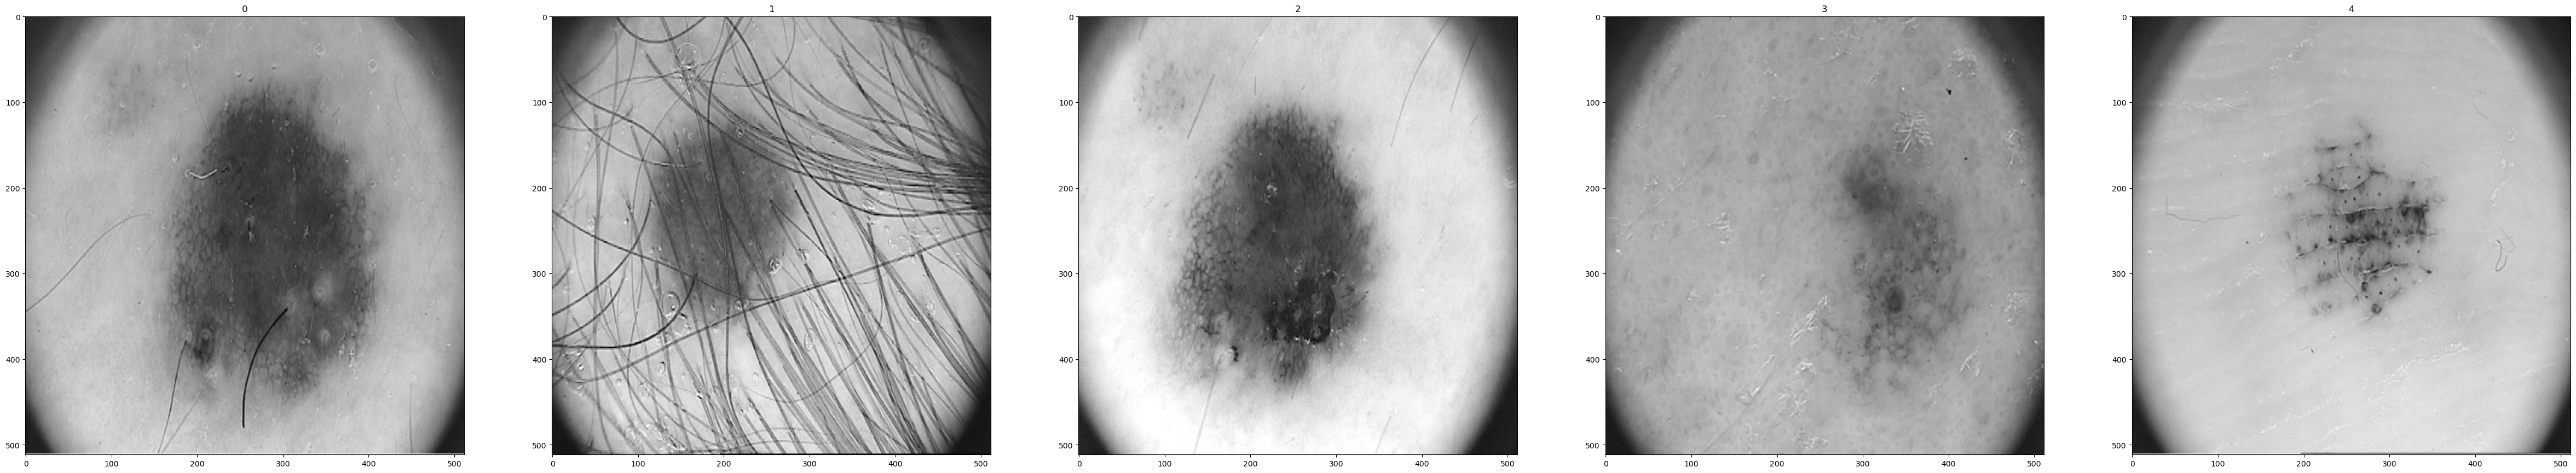

In [16]:
funcaoPlot(imagens_gray[:5])

In [17]:
imagens_otsu  = limiar_otsu(imagens_gray)

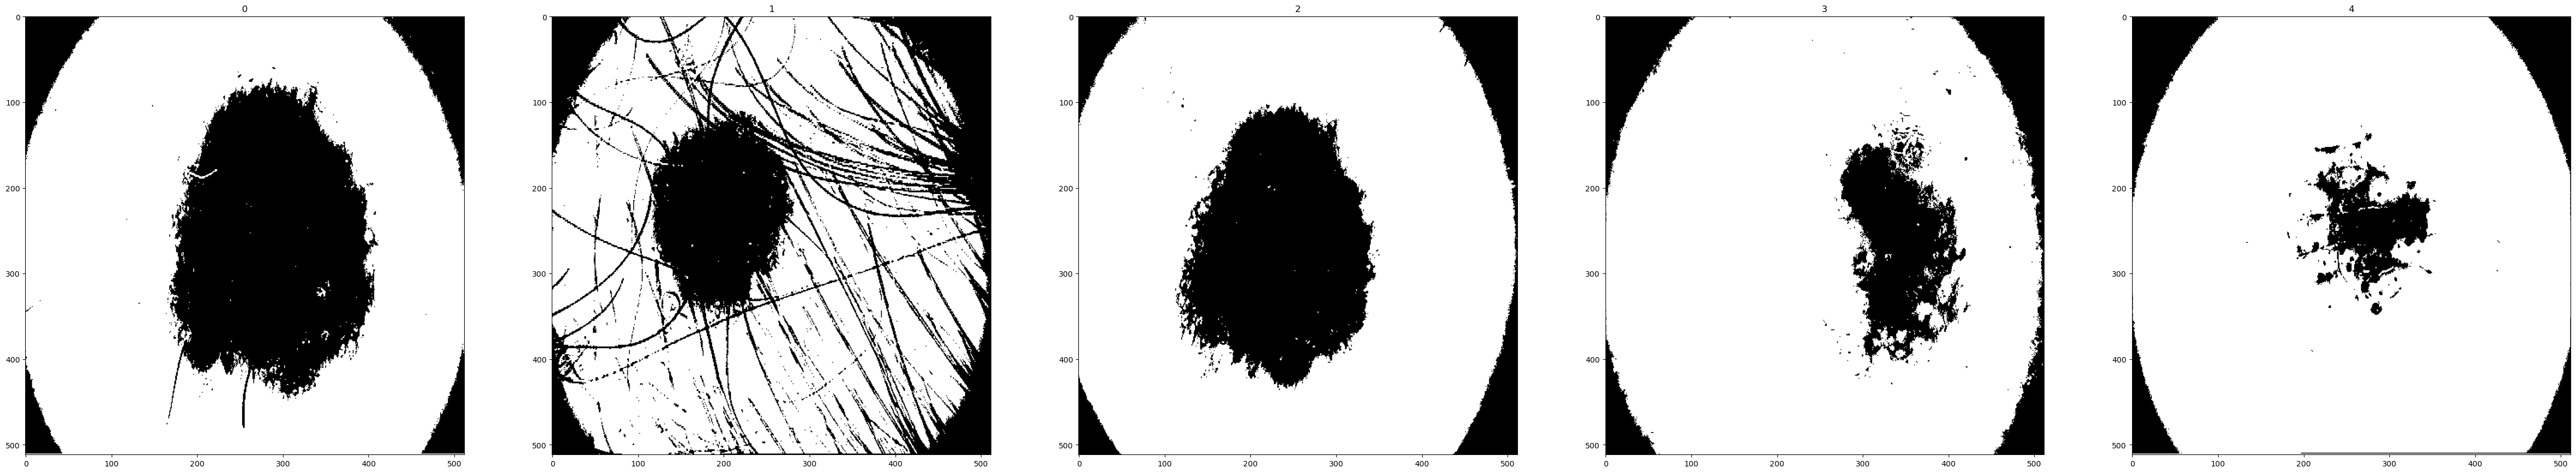

In [18]:
funcaoPlot(imagens_otsu[:5])

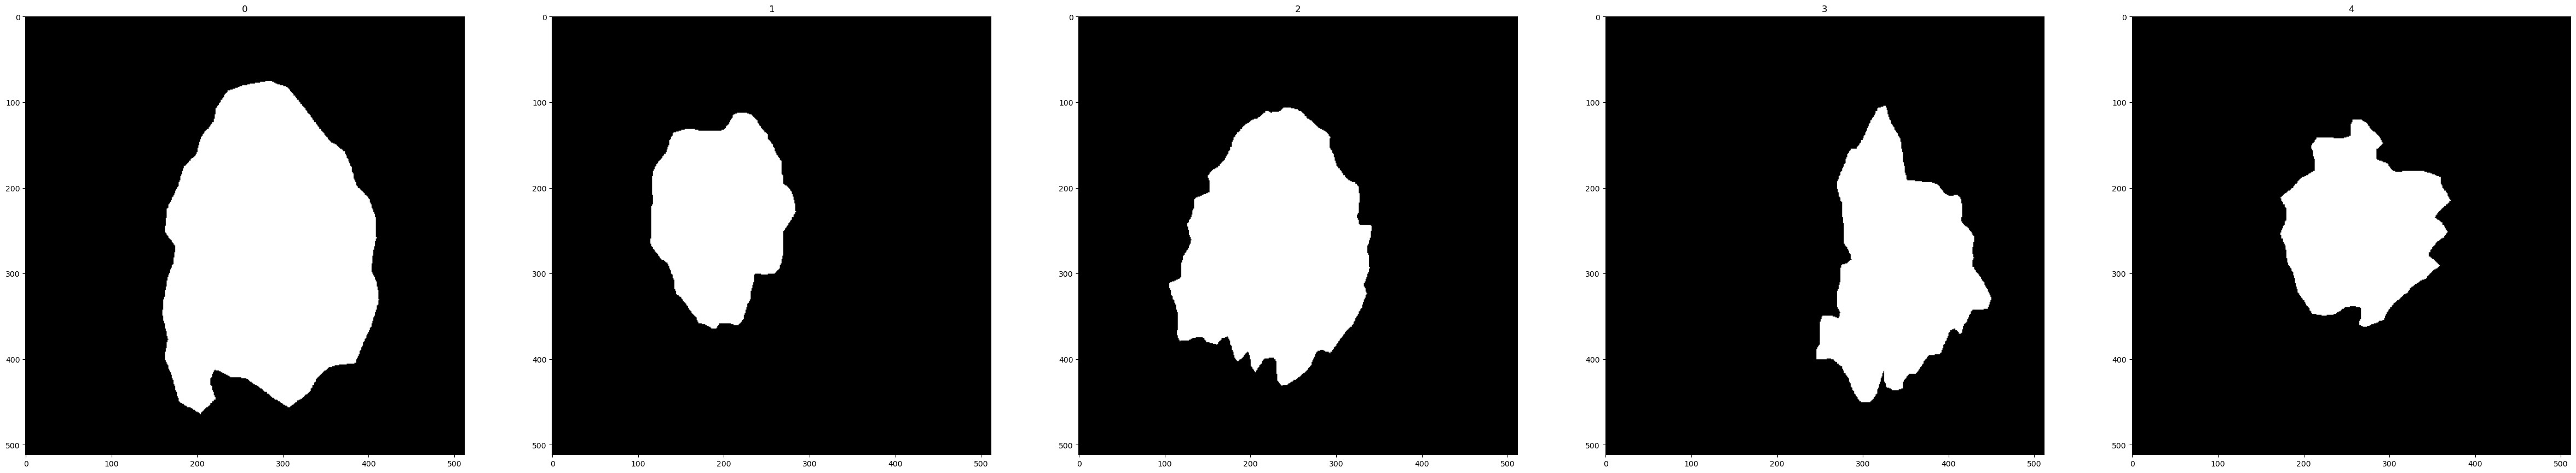

In [19]:
funcaoPlot(mascaras_medico[:5])

In [20]:
media_dice(imagens_otsu,mascaras_medico)

/tmp/ipykernel_8421/2125805178.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  imagem_b = np.asarray(imagem).astype(np.bool)
/tmp/ipykernel_8421/2125805178.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mascara_b = np.asarray(mascara).astype(np.bool)


0.17184501201625982

In [25]:
imagens_meanshift = aplicar_menshift(imagens_gray)

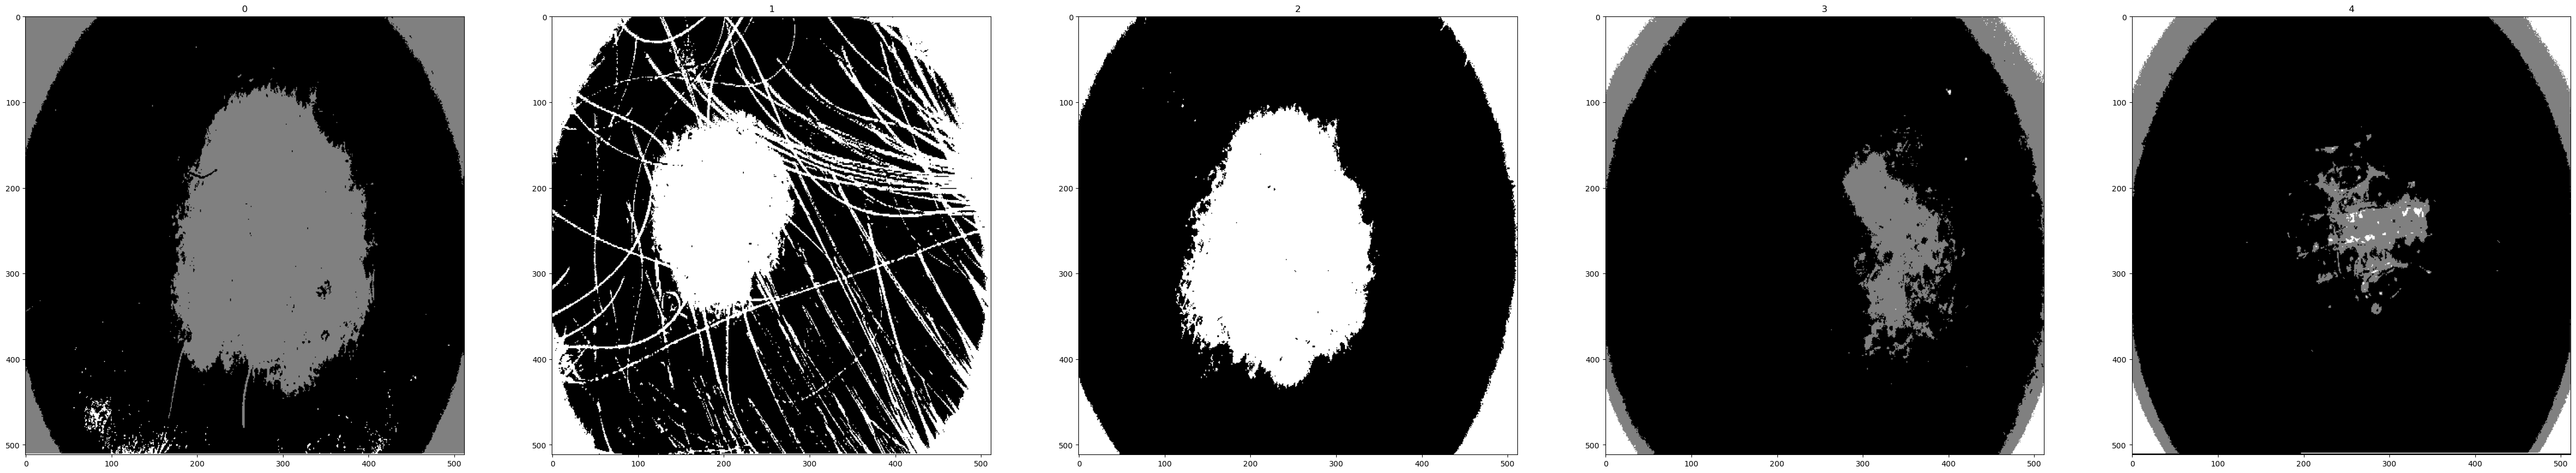

In [26]:
funcaoPlot(imagens_meanshift[:5])

In [27]:
media_dice(imagens_meanshift,mascaras_medico)

/tmp/ipykernel_8421/2125805178.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  imagem_b = np.asarray(imagem).astype(np.bool)
/tmp/ipykernel_8421/2125805178.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mascara_b = np.asarray(mascara).astype(np.bool)


0.48738638891802594

In [22]:
imagens_gmm = aplicar_gmm(imagens_gray)

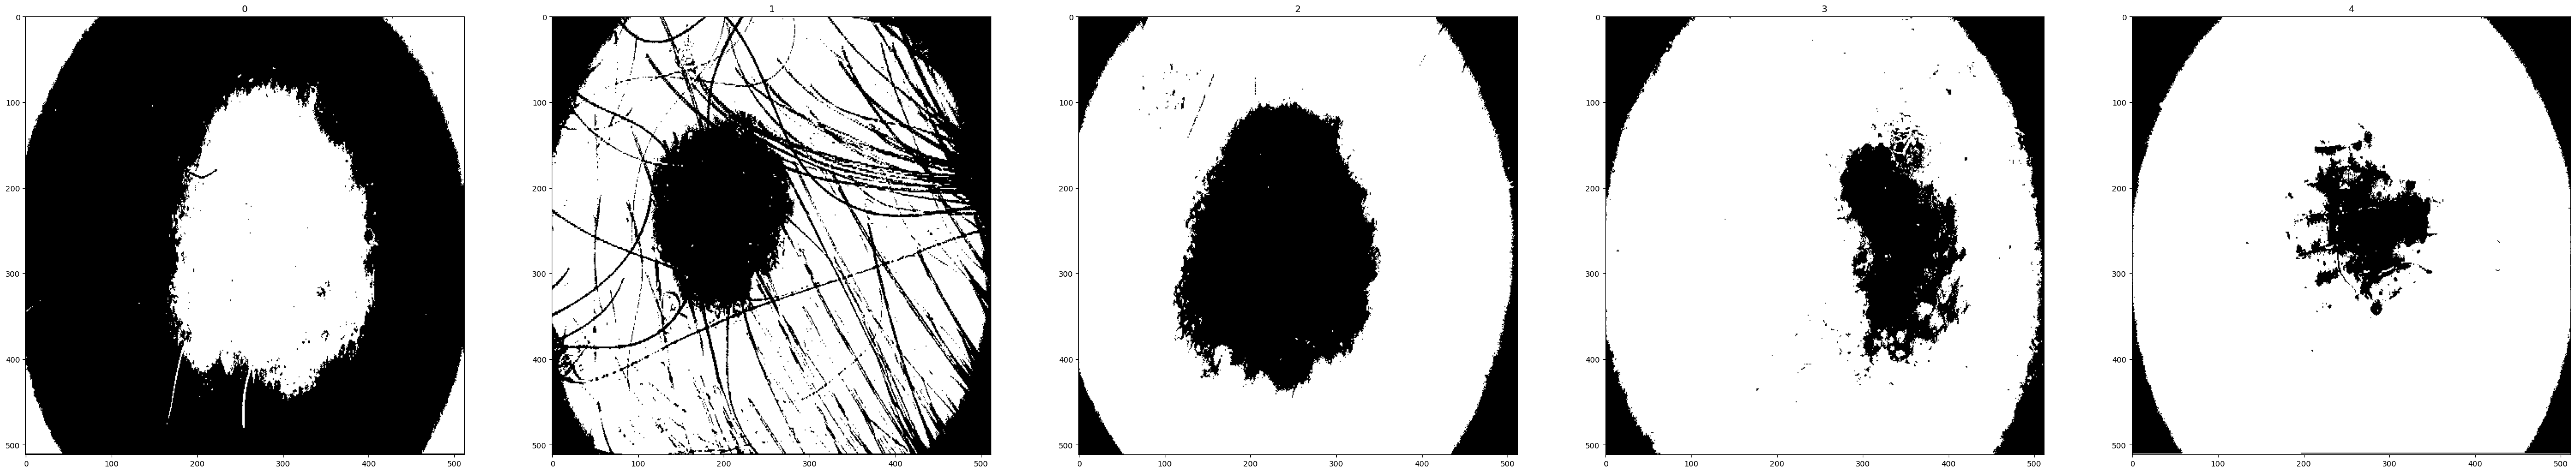

In [23]:
funcaoPlot(imagens_gmm[:5])

In [24]:
media_dice(imagens_gmm,mascaras_medico)

/tmp/ipykernel_8421/2125805178.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  imagem_b = np.asarray(imagem).astype(np.bool)
/tmp/ipykernel_8421/2125805178.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mascara_b = np.asarray(mascara).astype(np.bool)


0.41726234374833254

In [31]:
imagens_kmeans = aplicar_kmeans(imagens_gray)

/home/lucas/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/lucas/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/lucas/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/lucas/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to

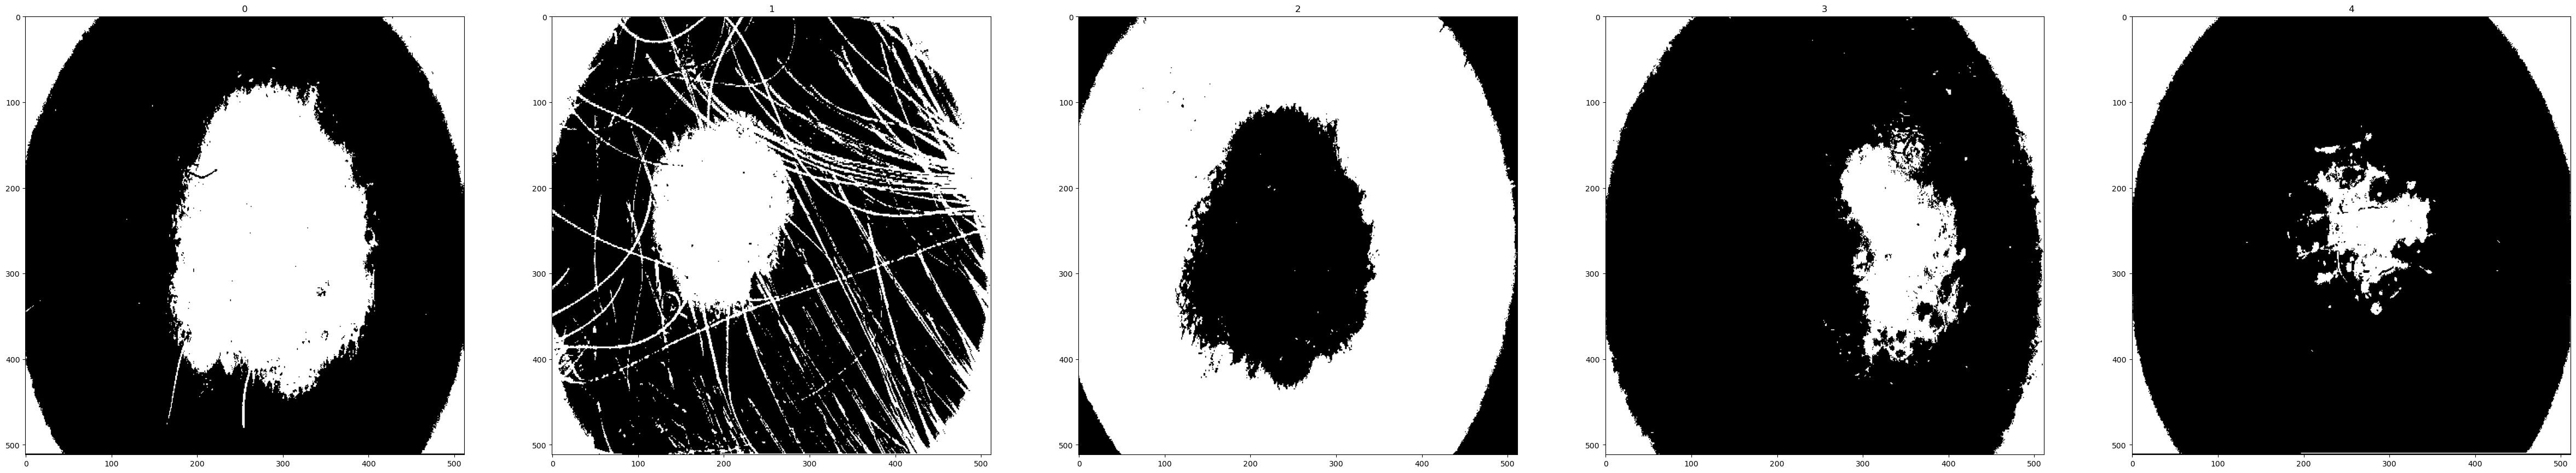

In [32]:
funcaoPlot(imagens_kmeans[:5])

In [33]:
media_dice(imagens_kmeans,mascaras_medico)

/tmp/ipykernel_8421/2125805178.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  imagem_b = np.asarray(imagem).astype(np.bool)
/tmp/ipykernel_8421/2125805178.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mascara_b = np.asarray(mascara).astype(np.bool)


0.5260467121402558

In [34]:
imagens_niblack = aplicar_niblack(imagens_gray)

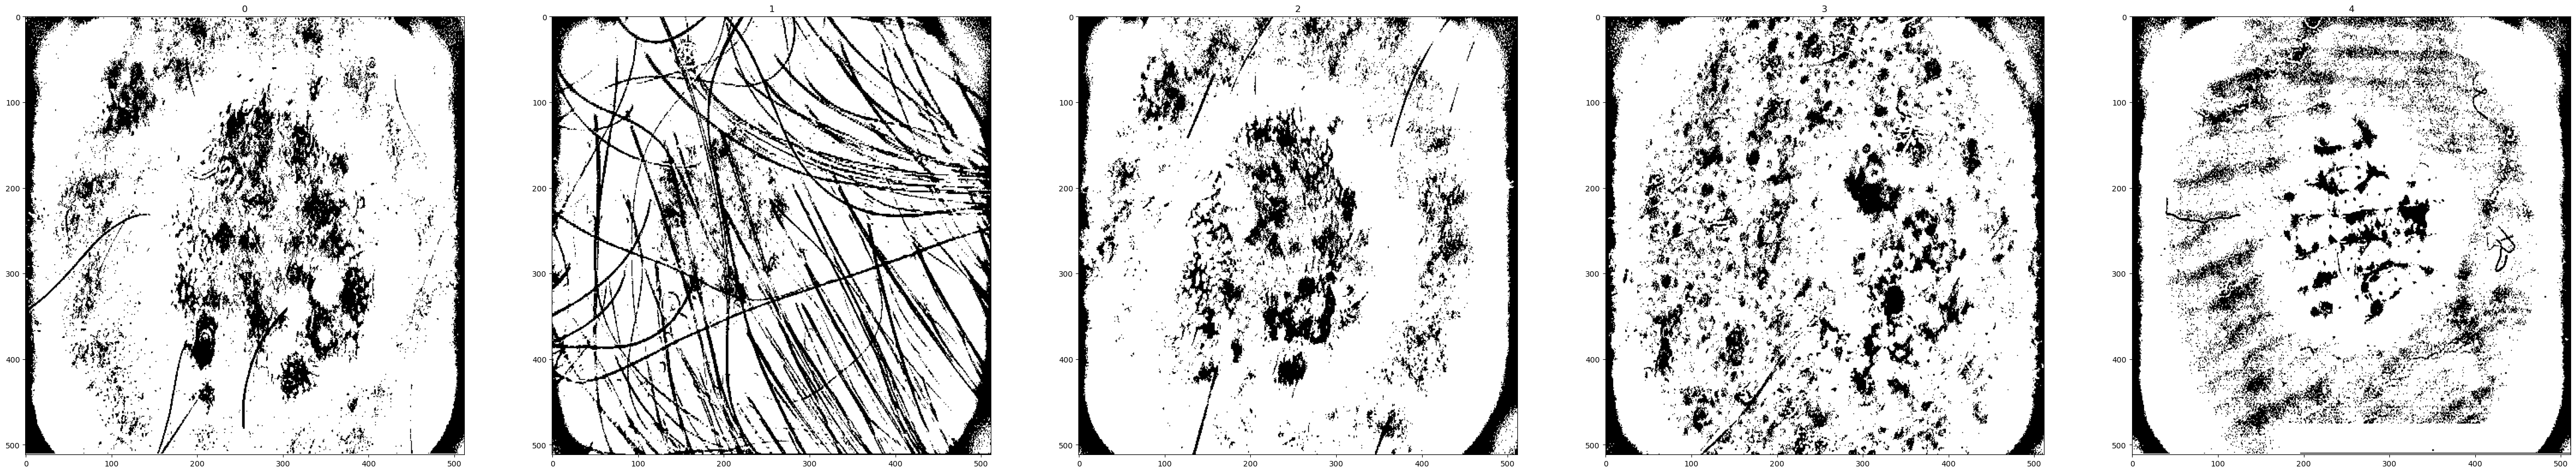

In [35]:
funcaoPlot(imagens_niblack[:5])

In [36]:
media_dice(imagens_niblack,mascaras_medico)

/tmp/ipykernel_8421/2125805178.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  imagem_b = np.asarray(imagem).astype(np.bool)
/tmp/ipykernel_8421/2125805178.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mascara_b = np.asarray(mascara).astype(np.bool)


0.3718773031978291